In [ ]:
!pip install tinker transformers dotenv 

In [1]:
import tinker
from tinker import types
import dotenv
import os
import json
dotenv.load_dotenv()
TINKER_API_KEY = os.getenv("TINKER_API_KEY")

In [2]:
TINKER_API_KEY

'tml-2b8sVND0ufiWAex6GjiPWgRR084MzYK8im8aXROUHIdJO3sj3oyG9cstvRz7laj3CAAAA'

In [2]:

service_client = tinker.ServiceClient(api_key=TINKER_API_KEY)
print("Available models:")
for item in service_client.get_server_capabilities().supported_models:
    print("- " + item.model_name)

Available models:
- deepseek-ai/DeepSeek-V3.1
- deepseek-ai/DeepSeek-V3.1-Base
- meta-llama/Llama-3.1-70B
- meta-llama/Llama-3.1-8B
- meta-llama/Llama-3.1-8B-Instruct
- meta-llama/Llama-3.2-1B
- meta-llama/Llama-3.2-3B
- meta-llama/Llama-3.3-70B-Instruct
- Qwen/Qwen3-235B-A22B-Instruct-2507
- Qwen/Qwen3-30B-A3B
- Qwen/Qwen3-30B-A3B-Base
- Qwen/Qwen3-30B-A3B-Instruct-2507
- Qwen/Qwen3-32B
- Qwen/Qwen3-4B-Instruct-2507
- Qwen/Qwen3-8B
- Qwen/Qwen3-8B-Base
- openai/gpt-oss-120b
- openai/gpt-oss-20b


In [4]:
base_model = "Qwen/Qwen3-30B-A3B-Instruct-2507"
training_client = service_client.create_lora_training_client(
    base_model=base_model
)

In [5]:
# Get the tokenizer from the training client
tokenizer = training_client.get_tokenizer()

/Users/bhushanshah/Documents/ARC-AGI-2/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
training_prompts_path = os.path.join("../data/arc-agi-2025/prompts/arc-agi_training_prompts.json")
validation_prompts_path = os.path.join("../data/arc-agi-2025/prompts/arc-agi_validation_prompts.json")

In [7]:
with open(training_prompts_path, 'r') as f:
    training_prompts = json.load(f)

with open(validation_prompts_path, 'r') as f:
    validation_prompts = json.load(f)

In [8]:
prompt_lengths = []
count = 0
for prompt in training_prompts + validation_prompts:
    input_ids = tokenizer.encode(prompt['prompt'] + prompt['output'])
    prompt_lengths.append(len(input_ids))
    count += 1
    if count % 50 == 0:
        print(f"Processed {count} prompts...")

Processed 50 prompts...
Processed 100 prompts...
Processed 100 prompts...
Processed 150 prompts...
Processed 150 prompts...
Processed 200 prompts...
Processed 200 prompts...
Processed 250 prompts...
Processed 250 prompts...
Processed 300 prompts...
Processed 300 prompts...
Processed 350 prompts...
Processed 350 prompts...
Processed 400 prompts...
Processed 400 prompts...
Processed 450 prompts...
Processed 450 prompts...
Processed 500 prompts...
Processed 500 prompts...
Processed 550 prompts...
Processed 550 prompts...
Processed 600 prompts...
Processed 600 prompts...
Processed 650 prompts...
Processed 650 prompts...
Processed 700 prompts...
Processed 700 prompts...
Processed 750 prompts...
Processed 750 prompts...
Processed 800 prompts...
Processed 800 prompts...
Processed 850 prompts...
Processed 850 prompts...
Processed 900 prompts...
Processed 900 prompts...
Processed 950 prompts...
Processed 950 prompts...
Processed 1000 prompts...
Processed 1000 prompts...
Processed 1050 prompts..

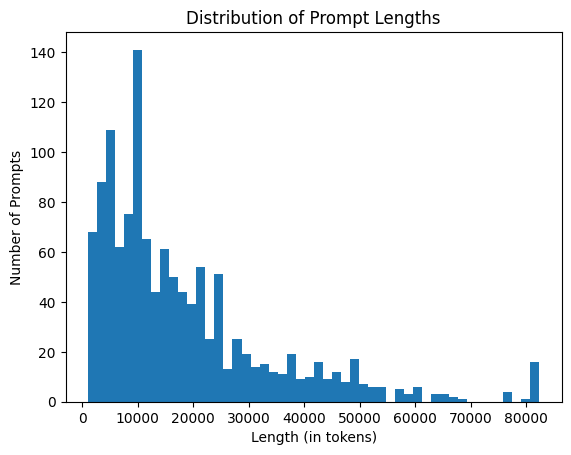

In [9]:
import matplotlib.pyplot as plt
plt.hist(prompt_lengths, bins=50)
plt.title("Distribution of Prompt Lengths")
plt.xlabel("Length (in tokens)")
plt.ylabel("Number of Prompts")
plt.show()

In [10]:
class Config:
    epochs = 5
    batch_size = 64
    learning_rate = 1e-4
    max_sequence_length = 32500
    lora_rank = 32

    def __init__(self, epochs=5, batch_size=64, learning_rate=1e-4, max_sequence_length=32500, lora_rank=32):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.max_sequence_length = max_sequence_length
        self.lora_rank = lora_rank

In [11]:
config = Config(learning_rate=5e-4, batch_size=64, epochs=5, max_sequence_length=32500, lora_rank=32)

In [12]:
new_training_prompts = []
new_validation_prompts = []
for prompt in training_prompts:
    input_ids = tokenizer.encode(prompt['prompt'] + prompt['output'])
    if len(input_ids) <= config.max_sequence_length:
        new_training_prompts.append(prompt)

for prompt in validation_prompts:
    input_ids = tokenizer.encode(prompt['prompt'] + prompt['output'])
    if len(input_ids) <= config.max_sequence_length:
        new_validation_prompts.append(prompt)



In [13]:
def process_example(example: dict, tokenizer) -> types.Datum:
    # Format the input with Input/Output template
    # For most real use cases, you'll want to use a renderer / chat template,
    # (see later docs) but here, we'll keep it simple.
    prompt = example['prompt']
    
    prompt_tokens = tokenizer.encode(prompt, add_special_tokens=True)
    prompt_weights = [0] * len(prompt_tokens)
    # Add a space before the output string, and finish with double newline
    completion_tokens = tokenizer.encode(example['output'], add_special_tokens=False)
    completion_weights = [1] * len(completion_tokens)
 
    tokens = prompt_tokens + completion_tokens
    weights = prompt_weights + completion_weights
 
    input_tokens = tokens[:-1]
    target_tokens = tokens[1:] # We're predicting the next token, so targets need to be shifted.
    weights = weights[1:]
 
    # A datum is a single training example for the loss function.
    # It has model_input, which is the input sequence that'll be passed into the LLM,
    # loss_fn_inputs, which is a dictionary of extra inputs used by the loss function.
    return types.Datum(
        model_input=types.ModelInput.from_ints(tokens=input_tokens),
        loss_fn_inputs=dict(weights=weights, target_tokens=target_tokens)
    )

In [14]:
processed_training_examples = [process_example(ex, tokenizer) for ex in new_training_prompts]

In [15]:
processed_validation_examples = [process_example(ex, tokenizer) for ex in new_validation_prompts]

In [16]:
# # Appended synchronous training loop (paste/run after preprocessing cells)
# import time
# import math
# import random
# import os
# import json
# from typing import List, Iterator

# # --- Safety checks ---
# assert 'training_client' in globals(), "training_client not found. Run the earlier cell that creates it."
# assert 'processed_training_examples' in globals(), "processed_training_examples not found. Run the preprocessing cell."
# assert 'config' in globals(), "config not found. Create or adjust Config in earlier cell."

# # Small helper: batch generator
# def batch_generator(examples: List[types.Datum], batch_size: int, shuffle: bool = True) -> Iterator[List[types.Datum]]:
#     idxs = list(range(len(examples)))
#     if shuffle:
#         random.shuffle(idxs)
#     for i in range(0, len(idxs), batch_size):
#         batch_idx = idxs[i:i+batch_size]
#         yield [examples[j] for j in batch_idx]

# # collate: return the batch as-is. If your client needs padding, modify this.
# def collate_batch(batch: List[types.Datum]) -> List[types.Datum]:
#     return batch

# # Training hyperparams from config
# epochs = getattr(config, "epochs", 5)
# batch_size = getattr(config, "batch_size", 64)
# learning_rate = getattr(config, "learning_rate", 5e-4)
# checkpoint_dir = "./tinker_checkpoints"
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Logging helpers
# def now():
#     return time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

# def save_checkpoint(step_num: int, metadata: dict = None):
#     checkpoint_meta = {
#         "step": step_num,
#         "timestamp": now()
#     }
#     if metadata:
#         checkpoint_meta.update(metadata)
#     path = os.path.join(checkpoint_dir, f"checkpoint_step_{step_num}.json")
#     with open(path, "w") as f:
#         json.dump(checkpoint_meta, f)
#     print(f"[{now()}] Saved local checkpoint metadata -> {path}")
#     try:
#         if hasattr(training_client, "save_checkpoint"):
#             print(f"[{now()}] Calling training_client.save_checkpoint(step={step_num})")
#             training_client.save_checkpoint(name=f"checkpoint_step_{step_num}")
#     except Exception as e:
#         print(f"[{now()}] Warning: saving checkpoint to remote failed: {e}")

# # Main training loop (synchronous)
# global_step = 0
# print(f"[{now()}] Starting training: epochs={epochs}, batch_size={batch_size}, lr={learning_rate}")

# for epoch in range(1, epochs + 1):
#     epoch_start = time.time()
#     epoch_loss_accum = 0.0
#     epoch_items = 0
#     batch_iter = batch_generator(processed_training_examples, batch_size, shuffle=True)
#     for batch in batch_iter:
#         global_step += 1
#         batch = collate_batch(batch)
#         try:
#             fb_out = training_client.forward_backward(batch)
#         except Exception as e:
#             # small retry/backoff on transient errors
#             print(f"[{now()}] forward_backward failed at step {global_step}: {e}. Retrying once...")
#             try:
#                 time.sleep(1.0)
#                 fb_out = training_client.forward_backward(batch)
#             except Exception as e2:
#                 print(f"[{now()}] Retry failed: {e2}. Skipping this batch.")
#                 continue

#         # extract loss (attempt common keys)
#         batch_loss = None
#         try:
#             if hasattr(fb_out, "loss_fn_outputs") and isinstance(fb_out.loss_fn_outputs, dict):
#                 for k, v in fb_out.loss_fn_outputs.items():
#                     if isinstance(v, (float, int)):
#                         batch_loss = float(v)
#                         break
#             if batch_loss is None and hasattr(fb_out, "output_diagnostics"):
#                 for k, v in fb_out.output_diagnostics.items():
#                     if isinstance(v, (float, int)):
#                         batch_loss = float(v)
#                         break
#         except Exception:
#             batch_loss = None

#         # Apply optimizer step
#         try:
#             if hasattr(training_client, "optim_step"):
#                 training_client.optim_step(learning_rate)
#             elif hasattr(training_client, "step_optimizer"):
#                 training_client.step_optimizer(learning_rate)
#             else:
#                 print(f"[{now()}] Warning: training_client has no known optim_step method; check docs.")
#         except Exception as e:
#             print(f"[{now()}] optim_step failed at step {global_step}: {e}")

#         # Logging
#         if batch_loss is not None:
#             epoch_loss_accum += batch_loss * len(batch)
#             epoch_items += len(batch)
#         if global_step % 10 == 0:
#             avg_loss_so_far = (epoch_loss_accum / epoch_items) if epoch_items > 0 else None
#             print(f"[{now()}] Epoch {epoch} step {global_step}  avg_loss_so_far={avg_loss_so_far}")

#         # Periodic checkpointing
#         if global_step % 200 == 0:
#             save_checkpoint(global_step, metadata={"epoch": epoch, "avg_loss_so_far": (epoch_loss_accum / epoch_items) if epoch_items else None})

#     # End of epoch
#     epoch_time = time.time() - epoch_start
#     epoch_avg_loss = (epoch_loss_accum / epoch_items) if epoch_items > 0 else None
#     print(f"[{now()}] Finished epoch {epoch}/{epochs}  time={epoch_time:.1f}s  avg_loss={epoch_avg_loss}")

#     # Save checkpoint per epoch
#     save_checkpoint(global_step, metadata={"epoch": epoch})

# print(f"[{now()}] Training complete. Total steps: {global_step}")

In [18]:
# Clean async training loop (improved/standalone). Paste/run after setup cells.
import asyncio
import time
import math
import os
import json
import random
import numpy as np
from typing import List, Iterator

# Preconditions (these are created in earlier cells):
assert 'training_client' in globals(), 'training_client not found. Run the earlier cell that creates it.'
assert 'processed_training_examples' in globals(), 'processed_training_examples not found. Run preprocessing.'
assert 'config' in globals(), 'config not found. Define or import Config.'

def batch_generator(examples: List[types.Datum], batch_size: int, shuffle: bool = True) -> Iterator[List[types.Datum]]:
    idxs = list(range(len(examples)))
    if shuffle:
        random.shuffle(idxs)
    for i in range(0, len(idxs), batch_size):
        yield [examples[j] for j in idxs[i:i+batch_size]]

def collate_batch(batch: List[types.Datum]) -> List[types.Datum]:
    # tinker typically accepts a list of Datum; pad here if your client requires tensors
    return batch

def compute_mean_nll(logprobs_list, weights_list):
    total = 0.0
    total_w = 0.0
    for lp_seq, w_seq in zip(logprobs_list, weights_list):
        # Handle TensorData or similar wrappers
        if hasattr(lp_seq, 'tolist'):
            lp_seq = lp_seq.tolist()
        elif hasattr(lp_seq, 'to_numpy'):
            lp_seq = lp_seq.to_numpy()

        if hasattr(w_seq, 'tolist'):
            w_seq = w_seq.tolist()
        elif hasattr(w_seq, 'to_numpy'):
            w_seq = w_seq.to_numpy()

        lp = np.array(lp_seq, dtype=float)
        w = np.array(w_seq, dtype=float)

        # ensure equal length
        if lp.shape != w.shape:
            min_len = min(lp.shape[0], w.shape[0])
            lp = lp[:min_len]
            w = w[:min_len]

        total += (-lp * w).sum()
        total_w += w.sum()

    return float(total / total_w) if total_w > 0 else None


# Hyperparameters
epochs = getattr(config, 'epochs', 5)
batch_size = getattr(config, 'batch_size', 64)
base_lr = getattr(config, 'learning_rate', 5e-4)
checkpoint_dir = './tinker_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

def now():
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())

def save_checkpoint(step_num: int, metadata: dict = None):
    checkpoint_meta = {'step': step_num, 'timestamp': now()}
    if metadata:
        checkpoint_meta.update(metadata)
    path = os.path.join(checkpoint_dir, f'checkpoint_step_{step_num}.json')
    with open(path, 'w') as f:
        json.dump(checkpoint_meta, f)
    print(f'[{now()}] Saved local checkpoint metadata -> {path}')
    try:
        if hasattr(training_client, 'save_checkpoint'):
            training_client.save_checkpoint(name=f'checkpoint_step_{step_num}')
    except Exception as e:
        print(f'[{now()}] Warning: remote checkpoint save failed: {e}')

# Async wrappers that prefer the async client API and fall back to sync calls in executor
async def call_forward_backward(batch):
    if hasattr(training_client, 'forward_backward_async'):
        maybe_coro = training_client.forward_backward_async(batch, loss_fn='cross_entropy')
        res = await maybe_coro if asyncio.iscoroutine(maybe_coro) else maybe_coro
        # handle future-like result objects returned by Tinker async APIs
        if hasattr(res, 'result_async'):
            return await res.result_async()
        if hasattr(res, 'result'):
            return res.result()
        return res
    else:
        loop = asyncio.get_running_loop()
        return await loop.run_in_executor(None, training_client.forward_backward, batch)

async def call_optim_step(adam_params):
    if hasattr(training_client, 'optim_step_async'):
        maybe_coro = training_client.optim_step_async(adam_params)
        res = await maybe_coro if asyncio.iscoroutine(maybe_coro) else maybe_coro
        if hasattr(res, 'result_async'):
            return await res.result_async()
        if hasattr(res, 'result'):
            return res.result()
        return res
    else:
        loop = asyncio.get_running_loop()
        return await loop.run_in_executor(None, training_client.optim_step, adam_params)

async def train_async():
    global_step = 0
    num_examples = len(processed_training_examples)
    steps_per_epoch = max(1, math.ceil(num_examples / batch_size))
    print(f'[{now()}] Starting async training: epochs={epochs}, batch_size={batch_size}, base_lr={base_lr}')

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        epoch_loss_accum = 0.0
        epoch_items = 0
        for batch in batch_generator(processed_training_examples, batch_size, shuffle=True):
            global_step += 1
            batch = collate_batch(batch)

            # linear LR schedule
            step = global_step - 1
            lr_mult = max(0.0, 1.0 - step / (steps_per_epoch * epochs))
            current_lr = base_lr * lr_mult
            adam_params = tinker.AdamParams(learning_rate=current_lr, beta1=0.9, beta2=0.95, eps=1e-8)

            # forward/backward (async-aware)
            try:
                fwd_res = await call_forward_backward(batch)
            except Exception as e:
                print(f'[{now()}] forward_backward failed at step {global_step}: {e}. Retrying once...')
                try:
                    await asyncio.sleep(1.0)
                    fwd_res = await call_forward_backward(batch)
                except Exception as e2:
                    print(f'[{now()}] Retry failed: {e2}. Skipping this batch.')
                    continue

            # optimizer step
            try:
                _ = await call_optim_step(adam_params)
            except Exception as e:
                print(f'[{now()}] optim_step failed at step {global_step}: {e}')

            # extract per-sequence logprobs following cookbook pattern
            train_logprobs = []
            try:
                lf_outputs = getattr(fwd_res, 'loss_fn_outputs', None)
                if isinstance(lf_outputs, list):
                    for entry in lf_outputs:
                        if isinstance(entry, dict) and 'logprobs' in entry:
                            train_logprobs.append(entry['logprobs'])
                elif isinstance(lf_outputs, dict) and 'logprobs' in lf_outputs:
                    train_logprobs = [lf_outputs['logprobs']]
                else:
                    # debug print once if unexpected structure
                    print(f'[{now()}] Unexpected loss_fn_outputs structure (truncated): {str(lf_outputs)[:400]}')
            except Exception as e:
                print(f'[{now()}] Could not extract loss_fn_outputs: {e}')

            train_weights = [d.loss_fn_inputs['weights'] for d in batch]
            train_nll = compute_mean_nll(train_logprobs, train_weights) if train_logprobs else None

            if train_nll is not None:
                epoch_loss_accum += train_nll * len(batch)
                epoch_items += len(batch)

            if global_step % 10 == 0:
                avg_loss_so_far = (epoch_loss_accum / epoch_items) if epoch_items > 0 else None
                print(f'[{now()}] Epoch {epoch} step {global_step}  avg_loss_so_far={avg_loss_so_far} lr={current_lr}')

            if global_step % 200 == 0:
                save_checkpoint(global_step, metadata={'epoch': epoch, 'avg_loss_so_far': (epoch_loss_accum / epoch_items) if epoch_items else None})

        # end epoch
        epoch_time = time.time() - epoch_start
        epoch_avg_loss = (epoch_loss_accum / epoch_items) if epoch_items > 0 else None
        print(f'[{now()}] Finished epoch {epoch}/{epochs} time={epoch_time:.1f}s avg_loss={epoch_avg_loss}')
        save_checkpoint(global_step, metadata={'epoch': epoch})

    print(f'[{now()}] Async training finished. Total steps: {global_step}')

# Run training. In Jupyter, top-level await works; otherwise use asyncio.run(train_async()).
await train_async()


[2025-10-24 01:36:37] Starting async training: epochs=5, batch_size=64, base_lr=0.0005
[2025-10-24 01:44:53] Epoch 1 step 10  avg_loss_so_far=0.02339751615738133 lr=0.00044
[2025-10-24 01:44:53] Epoch 1 step 10  avg_loss_so_far=0.02339751615738133 lr=0.00044
[2025-10-24 01:48:25] Finished epoch 1/5 time=708.1s avg_loss=0.022281535429219453
[2025-10-24 01:48:25] Saved local checkpoint metadata -> ./tinker_checkpoints/checkpoint_step_15.json
[2025-10-24 01:48:25] Finished epoch 1/5 time=708.1s avg_loss=0.022281535429219453
[2025-10-24 01:48:25] Saved local checkpoint metadata -> ./tinker_checkpoints/checkpoint_step_15.json
[2025-10-24 01:54:08] Epoch 2 step 20  avg_loss_so_far=0.016910625513625342 lr=0.0003733333333333333
[2025-10-24 01:54:08] Epoch 2 step 20  avg_loss_so_far=0.016910625513625342 lr=0.0003733333333333333
[2025-10-24 02:07:21] Epoch 2 step 30  avg_loss_so_far=0.014629881821749926 lr=0.0003066666666666667
[2025-10-24 02:07:21] Finished epoch 2/5 time=1135.5s avg_loss=0.014